In [ ]:
pip install label_studio
pip install label_studio_sdk
pip install nltk
pip install tqdm
pip install sklearn
pip install sklearn.cross_validation

# Data Loading

First we need to load our labled text data from label studio. For that we use label_studio_sdk client and project modules. 
For data analysis we are using pandas.

In [2]:
from label_studio_sdk import Client
from label_studio_sdk import project
import pandas as pd
import tqdm

Now we are extracting only the annotated data from the loaded data and we clean it finally to save it into a panda dataframe. The below function takes the label studio url and the API key to load the labeled data from studio and returns a data frame.

In [3]:
def from_label_studio_to_dataframe( LABEL_STUDIO_URL="",API_KEY=""):
     
    ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
    ls.check_connection()
    pro = project.Project.get_from_id(ls, "1")
    raw_data = project.Project.get_labeled_tasks(pro)
        

    df = pd.DataFrame(columns=["text", "types", "category", "values"])

    tag2val = {
        "Question_1_Company_specific": 0,
        "Question_1_Market_related": 1,
        "Question_2_specific": 0,
        "Question_2_open": 1,
        "Question_3_attack": 2,
        "Question_3_support": 0,
        "Question_3_neutral": 1,
        "Answer_1_specific": 0,
        "Answer_1_avoid_excuse": 1,
        "Answer_2_negative": 0,
        "Answer_2_positive": 1,
        "Answer_3_blame": 0,
        "Answer_3_no_blame": 1
    }


    for task in tqdm.tqdm(raw_data):
        annotations = task["annotations"][0]["result"]

        for ann in annotations:
            text = ann["value"]["text"]
            label = ann["value"]["labels"][0]
            

            # Ignore any odservation that does not have any of the question and answer categories
            # (ex: an observation that only labels the question QID_13)
            if len(label) < 7:
                continue

            # Get the category "Answer" or "Question" from the label
            types = "Answer" if "Answer" in label else "Question"
            # Get the category
            category = int(label.split("_")[1])
            # Get the value
            values = tag2val[label]
            # Add the observation to the dataframe
            df = df.append(
                {
                    "text": text,
                    "types": types,
                    "category": category,
                    "values": values
                },
                ignore_index=True)    

    return df

In [5]:
LABEL_STUDIO_URL = 'http://132.231.59.226:8080' #this address needs to be the same as the address the label-studio is hosted on.
API_KEY = '185528f3099e4928918ed4d84d33c91cdc2b3392' #please add your personal API_Key here to get your API_Key follow the Pictures below

data = from_label_studio_to_dataframe( LABEL_STUDIO_URL = LABEL_STUDIO_URL , API_KEY= API_KEY)
data
data.to_csv('data.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:09<00:00,  7.73it/s]


In [6]:
df = pd.read_csv('C:/Users/sweet/OneDrive/Desktop/DLTA/Assignment/Assignment2/assignment-2/data.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8472 entries, 0 to 8471
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8472 non-null   int64 
 1   text        8472 non-null   object
 2   types       8472 non-null   object
 3   category    8472 non-null   int64 
 4   values      8472 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 331.1+ KB


,Unnamed: 0,text,types,category,values
0,0,Good afternoon and thanks a lot for taking my...,Question,1,0
1,1,Good afternoon and thanks a lot for taking my ...,Question,2,0
2,2,Good afternoon and thanks a lot for taking my ...,Question,3,1
3,3,"No, I think that as it relates to the one, I t...",Answer,1,0
4,4,"No, I think that as it relates to the one, I ...",Answer,2,1
...,...,...,...,...,...
8467,8467,One of the areas obviously which has been a s...,Question,2,0
8468,8468,One of the areas obviously which has been a st...,Question,3,1
8469,8469,"Well, let's start with the first part of your ...",Answer,1,0
8470,8470,"Well, let's start with the first part of your ...",Answer,2,1


# Data Preprocessing 

We are focusing to generate a target model that tries to predict  only the ANSWER LABEL 2 ("Answer_2_negative": 0, "Answer_2_positive": 1) for the text.


In [7]:
indexnames= df[df["types"]=="Question"].index
df.drop(indexnames,inplace=True)
data= df[df["category"]==2]
data.drop(columns=["types","category","Unnamed: 0"],axis=1 ,inplace=True)
data.shape

C:\Users\sweet\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1516, 2)

In [8]:
data

,text,values
4,"No, I think that as it relates to the one, I ...",1
10,"Well, clearly, it surpassed all of our very hi...",1
16,"I think the last few years, not only for us bu...",1
22,"The core-on-core, well, yes, I don't think the...",0
28,"There's lots of everything, Simeon. We really ...",1
...,...,...
8443,"Great, Tom. And I think the reason why we beli...",1
8452,"Yes, I mean, as part of our prepared remarks, ...",1
8458,"I'll touch on one, maybe in a little bit of de...",1
8464,"Yes, sure. The performance of RPO, and as we g...",1


In [9]:
data["values"].value_counts()

1    1262
0     254
Name: values, dtype: int64

### Data cleaning

Before converting the input data to different textual models, we need to pre process the data by removing the stopwords,numbers,puncuations, leading and ending white space and converting the lowercases to uppercases.


nltk :  By default, NLTK (Natural Language Toolkit) includes a list of 40 stop words, including: “a”, “an”, “the”, “of”, “in”, etc. The stopwords in nltk are the most common words in data.
NLTK did not considered the word "however" to be a stop word and hence appending it to the list.This shows that there is no hard and fast rule as to what a stop word is and what it isn't.

re  : Importing re (regular expression) for fiinding and removing the numbers/digits using re.sub()

Snowball is a small string processing language for creating stemming algorithms for use in Information Retrieval, plus a collection of stemming algorithms implemented using it. Here we import the stemmer for english words.

In [10]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sweet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
snowStem = nltk.stem.SnowballStemmer('english')
sw_nltk = stopwords.words('english')
sw_nltk.append('however')

def my_preprocessor(processed_data, remove_stopwords = False, stemming = False):
    # remove numbers 
    processed_data = re.sub(r'\d+', '', processed_data)
    # remove punctuation
    processed_data = processed_data.translate(str.maketrans('','', string.punctuation))
    # remove spaces
    processed_data = processed_data.strip()
    #upper to lower
    processed_data = processed_data.lower()
    
    if stemming:
      # stemming
      processed_data = snowStem.stem(processed_data)
    
    if remove_stopwords:
        # remove stop words
        processed_data = ' '.join([word for word in processed_data.split() if not(word in sw_nltk)])
        
    
    return processed_data

In [12]:
data.loc[:, 'processed_data'] = [my_preprocessor(text, remove_stopwords = True) for text in data.text]

C:\Users\sweet\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [13]:
corpus=[]
for text in data["text"]:
    corpus.append(my_preprocessor(text, remove_stopwords = True))


In [14]:
target=data['values']

In [15]:
#re-arranging the df .

data = data[['text','processed_data','values']]
data

,text,processed_data,values
4,"No, I think that as it relates to the one, I ...",think relates one think weve got currently und...,1
10,"Well, clearly, it surpassed all of our very hi...",well clearly surpassed high expectations said ...,1
16,"I think the last few years, not only for us bu...",think last years us big gas retailers supermar...,1
22,"The core-on-core, well, yes, I don't think the...",coreoncore well yes dont think big surprises a...,0
28,"There's lots of everything, Simeon. We really ...",theres lots everything simeon really dont talk...,1
...,...,...,...
8443,"Great, Tom. And I think the reason why we beli...",great tom think reason believe midmarket oppor...,1
8452,"Yes, I mean, as part of our prepared remarks, ...",yes mean part prepared remarks talked fact ado...,1
8458,"I'll touch on one, maybe in a little bit of de...",ill touch one maybe little bit detail adobe ex...,1
8464,"Yes, sure. The performance of RPO, and as we g...",yes sure performance rpo go forward youll star...,1


We should transform our text data into something that our machine learning model understands. Basically, we need to convert the text into an array of vector embeddings. 

Here we will be converting the cleaned input data into 4 different textual represenations.
- Frequency embedding methods used - Bag of words and TF-IDF
- Topic embedding method used - LSA
- Word embedding method used - Word2Vec

we will train the models with logistic Regression and Random Forest classifier.

### Defining Functions for traing and validating models

To train and validate the classification model, we defined seperate functions. 
We import RandomForestClassifier and LogisticRegression from sklearn.

- Logistic regression is a simple yet very effective classification algorithm and it is commonly used for many binary classification tasks.
- We also wanted to try an ensemble learning algorithm for textual classification because it reduces the variance of predictions and also can result in predictions that are better than any single model.Hence we used randomForest classifier.

Below functions will take the training and testing data as input and returns the fitted model. As an evaluation metrics, it prints the accuracy of the model.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [17]:
#Classification implementation

def logistic_reg_train_model(xtrain,ytrain,xtest,ytest):
    log_reg = LogisticRegression(random_state=0)
    log_reg.fit(xtrain,ytrain)
    y_pred = log_reg.predict(xtest)
    log_accuracy = accuracy_score(ytest,y_pred)
    print (str(log_accuracy)+(" is the accuracy of the logistic regression model"))
    return log_reg
    
def Random_forest_train_model(xtrain,ytrain,xtest,ytest):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(xtrain, ytrain)
    predict_tfidf = rf.predict(xtest)
    rf_acc= accuracy_score(ytest,predict_tfidf)
    print(str(rf_acc)+(" is the accuracy of the RandomForestClassifier model"))
    return rf


These functions will take the validation data and the fitted model that is returened by the above function as input.
It prints the accuracy and returns the class probabilities for each data point(using  `predict_proba` method)

In [18]:
#validation

def logistic_reg_val_model(x_validation,y_validation,  log_reg):
    y_pred_lr = log_reg.predict(x_validation)
    yprob_lr = log_reg.predict_proba(x_validation)
    log_accuracy = accuracy_score(y_validation,y_pred_lr)
    print (str(log_accuracy)+(" is the Val_accuracy of the logistic regression model"))
    return yprob_lr

def random_forest_val_model(x_validation,y_validation, rf):
    y_pred_rf = rf.predict(x_validation)
    yprob_rf = rf.predict_proba(x_validation)
    rf_acc= accuracy_score(y_validation,y_pred_rf)
    print(str(rf_acc)+(" is the Val_accuracy of the RandomForestClassifier model"))
    return yprob_rf

### Defining Functions to plot evaluation metrices

- To evaluate the models we will be using both the ROC curve and Precision Recall curve. 
- Since the data is highly imbalanced, we would like to focus on the Precision Recall curve along with the accuracy of the model.

Below are the functions defined for ploting the curves for which we use sklearn and matplotlib.

In [19]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score,plot_precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt


In [20]:
def print_roc(y_validation,yhat_lr,yhat_rf):
    fpr_lr, tpr_lr, threshold = roc_curve(y_validation, yhat_lr[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    fpr_rf, tpr_rf, threshold = roc_curve(y_validation, yhat_rf[:,1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.figure(figsize=(6,6))
    plt.plot(fpr_lr, tpr_lr, label='logisticReg (area = %0.3f)' % roc_auc_lr, linewidth=2)
    plt.plot(fpr_rf, tpr_rf, label='RandomForest (area = %0.3f)' % roc_auc_rf, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic: is positive', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

In [21]:

def print_precision_recall_curve(y_validation,yhat_lr,yhat_rf):
    average_precision_lr = average_precision_score(y_validation, yhat_lr[:,1])
    print('average precision Logistic Regression :%0.3f' %average_precision_lr)
    average_precision_rf = average_precision_score(y_validation, yhat_rf[:,1])
    print('average precision Random Forest :%0.3f' %average_precision_rf)
    precision_lr, recall_lr, thresholds = precision_recall_curve(y_validation, yhat_lr[:,1])
    precision_rf, recall_rf, thresholds = precision_recall_curve(y_validation, yhat_rf[:,1])
    auc_precision_recall_lr = auc(recall_lr, precision_lr)
    auc_precision_recall_rf = auc(recall_rf, precision_rf)
    plt.figure(figsize=(6,6))
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision- Recall Curve', fontsize=16)
    plt.plot(recall_lr, precision_lr,label='logisticReg (area = %0.3f)' %auc_precision_recall_lr )
    plt.plot(recall_rf, precision_rf,label=' RandomForest (area = %0.3f)' %auc_precision_recall_rf )
    plt.legend(loc="upper right")
    plt.show()
    

#  Implementing Bag Of Words

First textual model we implement is bag of Words where we just keep track of word counts and disregard the grammatical details and the word order.
By using the BoW technique, we convert a text into its equivalent vector of numbers.

For this we need CountVectorize provided by the scikit-learn library.It is used to transform a given text into a vector on the basis of the frequency of each word that occurs in the entire text.


In [22]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [23]:
cv=CountVectorizer(ngram_range = (1,2), min_df= 2)
cv.fit(data['processed_data'])
bow = cv.transform(data['processed_data'])
data_in=bow.toarray()
data_in

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
term_freqs = pd.DataFrame(data = data_in.sum(axis = 0),
                          index=cv.get_feature_names_out(),
                          columns = ['frequency'])
term_freqs

,frequency
aaa,2
aah,5
aat,6
aat levels,2
ability,85
...,...
youve seen,24
zero,19
zero apr,2
zero billion,2


Now after getting the term frequencies, we need to split the data into test and train set. For this we used `train_test_split` from sklearn.
First we divided the data set into two subsets- train and test- in the ratio 70/30. The test data set is again split into two subsets in the ratio 50/50, test and validation, where the validation set is used to evaluate the modal once in the end. 

In [25]:
from sklearn.model_selection import train_test_split

In [26]:

SEED = 42
xtrain, x_validation_and_test, ytrain, y_validation_and_test = train_test_split(data_in, target, test_size=.3, random_state=SEED)
x_validation, xtest, y_validation, ytest = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [27]:
log_reg = logistic_reg_train_model(xtrain,ytrain,xtest,ytest)
rf = Random_forest_train_model(xtrain,ytrain,xtest,ytest)

0.8464912280701754 is the accuracy of the logistic regression model
0.868421052631579 is the accuracy of the RandomForestClassifier model


In [28]:
yhat_lr = logistic_reg_val_model(x_validation,y_validation,log_reg)
yhat_rf = random_forest_val_model(x_validation,y_validation,rf)

0.8458149779735683 is the Val_accuracy of the logistic regression model
0.8370044052863436 is the Val_accuracy of the RandomForestClassifier model


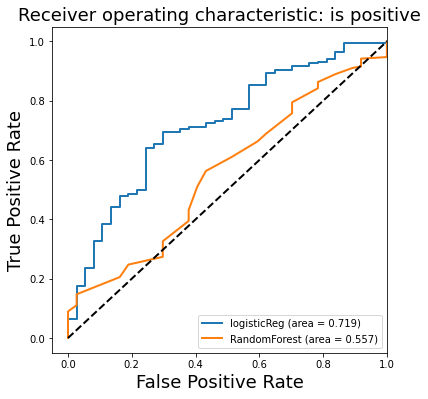

In [29]:
print_roc(y_validation,yhat_lr,yhat_rf)

average precision Logistic Regression :0.924
average precision Random Forest :0.872


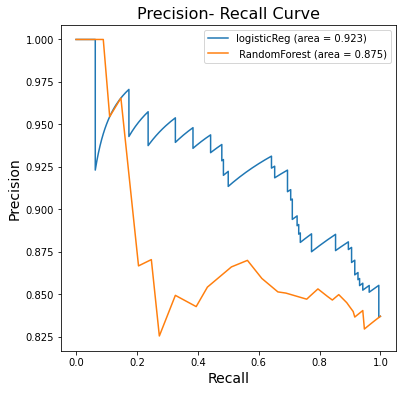

In [30]:
print_precision_recall_curve(y_validation,yhat_lr,yhat_rf)

From the above graphs, we can see that the ROC curve alone is not enough to understand how the model performs. Hence by looking at the Precision recall curve, its evident that the area under the curve for logistic regression model is high which relates to a low false positive and false negative rate.

# Implementing TFIDF 

The next input representation we tried is Term Frequency-Inverse Document Frequency. Which is also a frequency method.
We used TfidfVectorizer to convert the `processed_data` to a matrix of TF-IDF features. 
`min_df` is set to 2, because for frequency <2, these words could be ignored as they do not provide enough information on the entire dataset as a whole but only a couple of particular documents. When set to >2, the performance degrades. 
By setting `max_features` ,We are only selecting 1000 most common words in the data as features.

In [31]:
vect =TfidfVectorizer(ngram_range = (1, 2), min_df= 2, max_features=1000) 
vect_text=vect.fit_transform(data['processed_data'])

In [32]:
print(vect_text)
vect_text

  (0, 229)	0.18736693032840473
  (0, 878)	0.1974788596021854
  (0, 963)	0.1745617255055031
  (0, 964)	0.15913084238122918
  (0, 871)	0.18611904015603445
  (0, 605)	0.14349912902585799
  (0, 37)	0.15199135681909745
  (0, 39)	0.1913766608095672
  (0, 72)	0.16643368461081745
  (0, 567)	0.17547881182085245
  (0, 883)	0.1783706257555684
  (0, 381)	0.15051798931909016
  (0, 976)	0.12272027394791066
  (0, 612)	0.12536253131313785
  (0, 334)	0.10037652826924313
  (0, 942)	0.11206306966695159
  (0, 225)	0.20721186769057484
  (0, 881)	0.09508562988664553
  (0, 672)	0.13897214633118582
  (0, 905)	0.1481824565690322
  (0, 694)	0.15736041895922187
  (0, 988)	0.22771711096139138
  (0, 455)	0.10577296550003445
  (0, 224)	0.12928943860496964
  (0, 315)	0.34056224768374843
  :	:
  (1515, 604)	0.12179154449561301
  (1515, 367)	0.39099639847044065
  (1515, 895)	0.1292251200952837
  (1515, 182)	0.08628324171613465
  (1515, 362)	0.06327191782100482
  (1515, 598)	0.1597071461024959
  (1515, 743)	0.084967269

<1516x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 62268 stored elements in Compressed Sparse Row format>


Note that we are printing a sparse matrix so the output looks different compared to printing a standard dense matrix.

The main components:
- The tuple represents: (document_id, token_id)
- The value following the tuple represents: the tf-idf score of a given token in a given document
- The tuples that are not there have a tf-idf score of 0

In [33]:
SEED = 42
xtrain, x_validation_and_test, ytrain, y_validation_and_test = train_test_split(vect_text, target, test_size=.3, random_state=SEED)
x_validation, xtest, y_validation, ytest = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [34]:
log_reg = logistic_reg_train_model(xtrain,ytrain,xtest,ytest)
rf = Random_forest_train_model(xtrain,ytrain,xtest,ytest)

0.868421052631579 is the accuracy of the logistic regression model
0.8728070175438597 is the accuracy of the RandomForestClassifier model


In [35]:
yhat_lr = logistic_reg_val_model(x_validation,y_validation, log_reg)
yhat_rf = random_forest_val_model(x_validation,y_validation, rf)

0.8370044052863436 is the Val_accuracy of the logistic regression model
0.8414096916299559 is the Val_accuracy of the RandomForestClassifier model


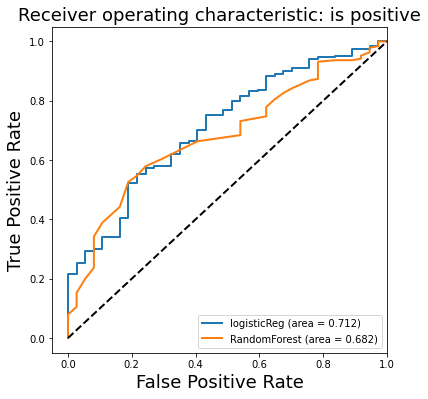

In [36]:
print_roc(y_validation,yhat_lr,yhat_rf)

average precision Logistic Regression :0.928
average precision Random Forest :0.916


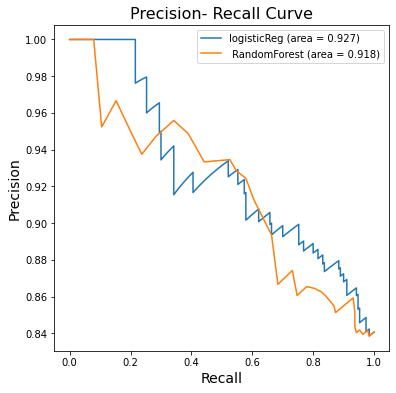

In [37]:
print_precision_recall_curve(y_validation,yhat_lr,yhat_rf)

Similar to BOW method, the area under precision recall curve is high for TF-IDF but comparitively better ROC curve. 

# LSA topic modelling

For topic modelling methods, we are implementing LSA, which is basically singular value decomposition.
We use the truncatedSVD function to implement LSA. In particular, truncated SVD works on tf-idf matrices.In that
context, it is known as latent semantic analysis (LSA).

The `n_components` parameter is the number of topics we wish to extract. `n_iter` is the number of iterations for randomized SVD solver.

The model is then fit and transformed on the result given by vectorizer, in our case,`vect_text`

In [38]:
from sklearn.decomposition import TruncatedSVD


In [39]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)
lsa=lsa_model.fit(vect_text)
lsa = lsa.transform(vect_text)
print(lsa)
print(lsa.shape)

[[ 0.25674434 -0.14594898 -0.05785493 ... -0.03850895 -0.01641734
  -0.06988173]
 [ 0.32815178 -0.02816948 -0.01904306 ... -0.01186182 -0.03907179
  -0.05854045]
 [ 0.2675077   0.02529883 -0.08297604 ... -0.05920995 -0.15866344
  -0.03913549]
 ...
 [ 0.32768822 -0.12989532  0.03838034 ...  0.05670951 -0.13425608
  -0.02983436]
 [ 0.25275698  0.09701607 -0.06105851 ... -0.07478824  0.14431388
   0.12948378]
 [ 0.23542575  0.03234139 -0.00728023 ... -0.04781513  0.09940278
  -0.02798296]]
(1516, 10)


In [40]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(10, 1000)
[[ 0.02365243  0.05829043  0.01342356 ...  0.01211691  0.02143617
   0.0087154 ]
 [-0.02198967 -0.05650072 -0.00087921 ... -0.00612958 -0.01455889
  -0.0014916 ]
 [ 0.01319814  0.03700712  0.0036878  ... -0.01304037 -0.01732791
  -0.01001207]
 ...
 [ 0.00876168  0.034043   -0.00165268 ...  0.012525   -0.00817255
  -0.01501864]
 [-0.00375625  0.00895033  0.01593203 ... -0.0107666  -0.00067362
   0.00994596]
 [-0.0080326  -0.01445718  0.01236531 ...  0.01067004 -0.01094246
   0.00522221]]


In [41]:
#printing the topics we extracted from the first document.

l=lsa[0]
print("Document 1 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 1 :
Topic  0  :  25.67443407023883
Topic  1  :  -14.594897735797153
Topic  2  :  -5.785492722123198
Topic  3  :  8.521294858215404
Topic  4  :  1.7727802608514518
Topic  5  :  -6.689250632013877
Topic  6  :  -10.380711973500677
Topic  7  :  -3.850895155279159
Topic  8  :  -1.64173449642345
Topic  9  :  -6.9881731842950465


In [42]:
# Print the Keywords in the 10 topics

vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
think going well us year really weve thats business see 

Topic 1: 
we quarter re we re year it growth revenue ve we ve 

Topic 2: 
we re we re it ve we ve that ll we ll users 

Topic 3: 
patients data first year would question yes dont studies first question 

Topic 4: 
yes think little dont yes think bit little bit way going way think 

Topic 5: 
yes customers also year across platform customer mentioned products new 

Topic 6: 
quarter patients think third quarter third product fourth quarter margin data fourth 

Topic 7: 
margin gross gross margin going one cost price product margins get 

Topic 8: 
think business margin growth patients well revenue gross continue gross margin 

Topic 9: 
business dont patients would growth know say going yes get 



C:\Users\sweet\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:

SEED = 42
xtrain, x_validation_and_test, ytrain, y_validation_and_test = train_test_split(lsa, target, test_size=.3, random_state=SEED)
x_validation, xtest, y_validation, ytest = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [44]:
log_reg = logistic_reg_train_model(xtrain,ytrain,xtest,ytest)
rf = Random_forest_train_model(xtrain,ytrain,xtest,ytest)

0.868421052631579 is the accuracy of the logistic regression model
0.8728070175438597 is the accuracy of the RandomForestClassifier model


In [45]:
yhat_lr = logistic_reg_val_model(x_validation,y_validation, log_reg)
yhat_rf = random_forest_val_model(x_validation,y_validation, rf)

0.8370044052863436 is the Val_accuracy of the logistic regression model
0.8502202643171806 is the Val_accuracy of the RandomForestClassifier model


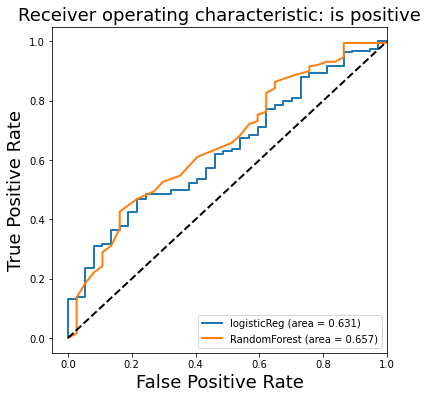

In [46]:
print_roc(y_validation,yhat_lr,yhat_rf)

average precision Logistic Regression :0.904
average precision Random Forest :0.897


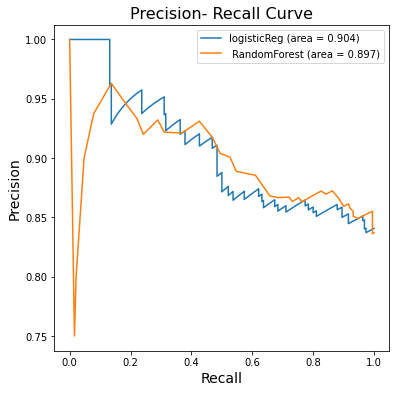

In [47]:
print_precision_recall_curve(y_validation,yhat_lr,yhat_rf)

The graphs show a slight decrease in the areas under both ROC curve and precision recall curve than the frequency methods.

# word2vec - CBOW

The word embedding method we used here is CBOW.
We use 
- Gensim: a free open-source Python library for representing documents as semantic vectors and is designed to process raw, plain text using unsupervised machine learning algorithms.

The word2vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling.

First we split the `processed_data` into words which can be an iterable for training the `Word2Vec`model.We used `epoch` 5 ,  since increasing the epochs is not improving the performance although it actually makes the resulting word embeddings more accurate.


In [48]:
from gensim.models import Word2Vec, Phrases
import nltk

In [49]:
embedding_dim = 200
window_size = 5
count = 3
epoch = 15
sg= 0 #The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

words = [text.split() for text in data['processed_data']]
word2vec = Word2Vec(words, min_count=count, vector_size= embedding_dim, window = window_size, epochs = epoch , sg= sg)

In [50]:
words[0][:8]

['think', 'relates', 'one', 'think', 'weve', 'got', 'currently', 'underway']

In [51]:
vocabulary = word2vec.wv.key_to_index
#print(vocabulary)

In [52]:
sim_words = word2vec.wv.most_similar('quarters')
sim_words

[('weeks', 0.9606545567512512),
 ('six', 0.948232889175415),
 ('months', 0.9446751475334167),
 ('call', 0.9256205558776855),
 ('three', 0.9128668308258057),
 ('four', 0.909765362739563),
 ('days', 0.905681312084198),
 ('wage', 0.9053879976272583),
 ('seven', 0.8940609693527222),
 ('couple', 0.8931562304496765)]

In [53]:
bigrams = Phrases(sentences=words)
trigrams = Phrases(sentences=bigrams[words])

For training the model, the input data should be vectorized. Since each of the sentences in the dataset is not of equal length we use padding.
After trying out certain values  for  `maxlen`,  found that increasing the padding degraded the performance hence applying the default value which will take the longest sequence length


In [54]:
from keras.preprocessing.sequence import pad_sequences

def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[corpus]]
print('Convert sentences to sentences with ngrams... (done)')

sequences=vectorize_data(X_data, vocab=word2vec.wv.key_to_index)
X_pad = pad_sequences(
    sequences=sequences,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [55]:
SEED = 42
xtrain, x_validation_and_test, ytrain, y_validation_and_test = train_test_split(X_pad, target, test_size=.3, random_state=SEED)
x_validation, xtest, y_validation, ytest = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [56]:
log_reg = logistic_reg_train_model(xtrain,ytrain,xtest,ytest)
rf = Random_forest_train_model(xtrain,ytrain,xtest,ytest)

C:\Users\sweet\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8026315789473685 is the accuracy of the logistic regression model
0.8728070175438597 is the accuracy of the RandomForestClassifier model


In [57]:
yhat_lr = logistic_reg_val_model(x_validation,y_validation, log_reg)
yhat_rf = random_forest_val_model(x_validation,y_validation, rf)

0.7709251101321586 is the Val_accuracy of the logistic regression model
0.8325991189427313 is the Val_accuracy of the RandomForestClassifier model


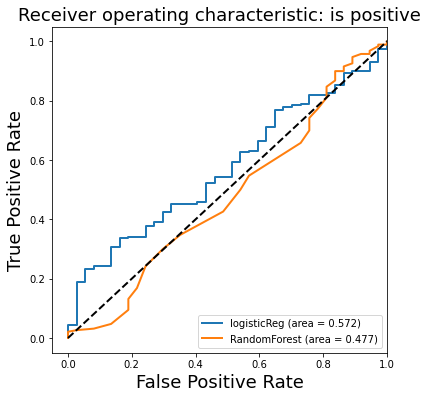

In [58]:
print_roc(y_validation,yhat_lr,yhat_rf)

average precision Logistic Regression :0.884
average precision Random Forest :0.824


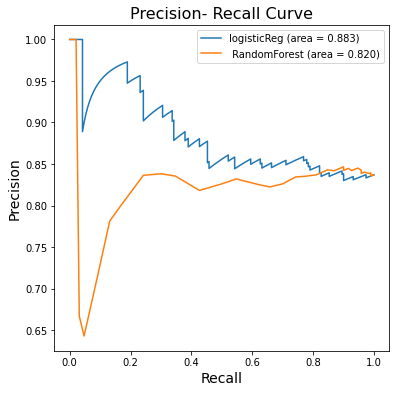

In [59]:
print_precision_recall_curve(y_validation,yhat_lr,yhat_rf)

### Results

We have tested the model on the validation set to check the final results. We will compare two different models: 1. logistic regression 2. Random Forest Classifier for all the text modelling methods.

The below table shows the validation accuracy for the models wrt different input methods.


|Input Method|   Logistic Regression       |Random Forest Classifier|
|:----:|:----:|:----:|
|BOW| 0.845 |0.837|
|Tf-IDF|0.837 |0.841|
|LSA| 0.837|0.850|
|CBOW|0.770 |0.832|

For the small data set in which we tried 4 different methods and two models,It is clear that even though it dosent make much differences, 
- Random forest classifier performs better than Logistic regression for all the text modelling methods. 
- The accuracy for word2vec model is little bit less compared to all others. Both LSA and Tf-idf yields good performance from the model.